# Match Prediction

### Import Data

In [3]:
import pandas as pd
pd.options.display.max_columns = None # I like to see all the columns

# Import past fixtures
fixtures = pd.read_pickle('../data/EPL_00-01_to_24-25.pkl')

fixtures

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA,season
0,E0,2000-08-19,Charlton,Man City,4,0,H,2.10,3.2,3.10,0001
1,E0,2000-08-19,Chelsea,West Ham,4,2,H,1.44,3.6,6.50,0001
2,E0,2000-08-19,Coventry,Middlesbrough,1,3,A,2.30,3.2,2.62,0001
3,E0,2000-08-19,Derby,Southampton,2,2,D,2.00,3.2,3.20,0001
4,E0,2000-08-19,Leeds,Everton,2,0,H,1.61,3.5,4.50,0001
...,...,...,...,...,...,...,...,...,...,...,...
8971,E0,2024-09-28,Nott'm Forest,Fulham,0,1,A,2.38,3.3,3.10,2425
8972,E0,2024-09-28,Wolves,Liverpool,1,2,A,8.00,5.5,1.35,2425
8973,E0,2024-09-29,Ipswich,Aston Villa,2,2,D,4.00,3.7,1.91,2425
8974,E0,2024-09-29,Man United,Tottenham,0,3,A,2.30,4.0,2.75,2425


In [7]:
import json

# Import relegated/promoted teams information
with open('../data/promotion_relegation.json', 'r') as json_file:
    rel_prom_teams = json.load(json_file)

rel_prom_teams["2324"]

{'relegated': ['Everton', 'Sheffield United', 'Burnley'],
 'promoted': ['Leicester', 'Ipswich', 'Southampton']}

### Calculating Team Stats

- Each team will be given offensive and defensive statistics in the form of a multiplier, representing how many goals they score and concede relative to the average.
- Stats will be calculated based on performance in the team's last 19 games (half a season).
- Teams will start off with ratings of 1.0. Newly promoted teams will be initialised with the average stats of the 3 teams that were relegated.
- Averages will be calculated on a rolling basis, separately for home and away.

In [74]:
import numpy as np

all_teams = fixtures['HomeTeam'].unique().tolist()

# Each team will have a list of their previous 19 performance multipliers
# Stats will be calculated as the mean of these performance ratings
# Each time a team plays, their newest performance multipliers will be added to the lists and the oldest will be popped from the lists
# Each team also has a counter of how many games we have to calculate stats from. This will be use to mark more uncertain predictions 
stats_dict = {team: {'off': [1.0] * 19, 'def': [1.0] * 19, 'count': 0} for team in all_teams}

# Similar system for averages, starting with an estimate
avg_dict = {'home': [1.7] * 190, 'away': [1.2] * 190}

# Initialise columns for stats
fixtures[['h_avg', 'a_avg', 'h_off', 'h_def', 'a_off', 'a_def', 'uncertain']] = 1.0

current_season = "0001" # Tracking season so that promoted/relegated teams can be dealt with
for i, row in fixtures.iterrows():

    season = row['season']
    h_team, a_team = row['HomeTeam'], row['AwayTeam']
    h_goals, a_goals = row['FTHG'], row['FTAG']
    uncertain = 0

    # Check if new season
    if season != current_season:
        
        # Calculate average stats of relegated teams
        relegated_off_avg = np.mean([np.mean(stats_dict[team]['off']) for team in rel_prom_teams[current_season]['relegated']])
        relegated_def_avg = np.mean([np.mean(stats_dict[team]['def']) for team in rel_prom_teams[current_season]['relegated']])

        # Attribute to promoted teams
        for team in rel_prom_teams[current_season]['promoted']:
            stats_dict[team]['off'] = [relegated_off_avg] * 19
            stats_dict[team]['def'] = [relegated_def_avg] * 19
            stats_dict[team]['count'] = 0 # Reset count to zero in case a previously relegated team is promoted back up. I only want to use recent data.

        # Update current season
        current_season = season

    # Calculate team stats and averages prior to current game
    h_avg, a_avg = np.mean(avg_dict['home']), np.mean(avg_dict['away'])
    h_off, h_def = np.mean(stats_dict[h_team]['off']), np.mean(stats_dict[h_team]['def'])
    a_off, a_def = np.mean(stats_dict[a_team]['off']), np.mean(stats_dict[a_team]['def'])

    # Mark uncertain games
    if stats_dict[h_team]['count'] < 19 or stats_dict[a_team]['count'] < 19:
        uncertain = 1

    # Update fixture stats
    fixtures.loc[i, ['h_avg', 'a_avg', 'h_off', 'h_def', 'a_off', 'a_def', 'uncertain']] = [h_avg, a_avg, h_off, h_def, a_off, a_def, uncertain]

    # Calculate performance multipliers for this game
    # A performance rating takes the opponent's quality into account. It is the multiplier of how they performed relative to how an average team would perform against the opponent.
    h_off_game = h_goals / (h_avg * a_def)
    h_def_game = a_goals / (a_avg * a_off)
    a_off_game = a_goals / (a_avg * h_def)
    a_def_game = h_goals / (h_avg * h_off)

    # Update stats dicts with data from this game
    stats_dict[h_team]['off'].pop(0)
    stats_dict[h_team]['off'].append(h_off_game)
    stats_dict[h_team]['def'].pop(0)
    stats_dict[h_team]['def'].append(h_def_game)
    stats_dict[h_team]['count'] += 1

    stats_dict[a_team]['off'].pop(0)
    stats_dict[a_team]['off'].append(a_off_game)
    stats_dict[a_team]['def'].pop(0)
    stats_dict[a_team]['def'].append(a_def_game)
    stats_dict[a_team]['count'] += 1
    
    avg_dict['home'].pop(0)
    avg_dict['home'].append(h_goals)
    avg_dict['away'].pop(0)
    avg_dict['away'].append(a_goals)

fixtures

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA,season,h_avg,a_avg,h_off,h_def,a_off,a_def,h_mean,a_mean,H_prob,D_prob,A_prob,pred_result,uncertain
0,E0,2000-08-19,Charlton,Man City,4,0,H,2.10,3.2,3.10,0001,1.700000,1.200000,1.000000,1.000000,1.000000,1.000000,1.700000,1.200000,0.490882,0.239290,0.269826,H,1.0
1,E0,2000-08-19,Chelsea,West Ham,4,2,H,1.44,3.6,6.50,0001,1.712105,1.193684,1.000000,1.000000,1.000000,1.000000,1.712105,1.193684,0.495212,0.238403,0.266383,H,1.0
2,E0,2000-08-19,Coventry,Middlesbrough,1,3,A,2.30,3.2,2.62,0001,1.724211,1.197895,1.000000,1.000000,1.000000,1.000000,1.724211,1.197895,0.497132,0.237403,0.265463,H,1.0
3,E0,2000-08-19,Derby,Southampton,2,2,D,2.00,3.2,3.20,0001,1.720526,1.207368,1.000000,1.000000,1.000000,1.000000,1.720526,1.207368,0.494101,0.237598,0.268299,H,1.0
4,E0,2000-08-19,Leeds,Everton,2,0,H,1.61,3.5,4.50,0001,1.722105,1.211579,1.000000,1.000000,1.000000,1.000000,1.722105,1.211579,0.493520,0.237431,0.269047,H,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,E0,2024-09-28,Nott'm Forest,Fulham,0,1,A,2.38,3.3,3.10,2425,1.752632,1.457895,0.827418,0.777947,0.930132,0.777589,1.127627,1.054923,0.372131,0.292452,0.335417,H,0.0
8972,E0,2024-09-28,Wolves,Liverpool,1,2,A,8.00,5.5,1.35,2425,1.752632,1.436842,0.600608,0.965194,1.360583,0.580086,0.610624,1.886899,0.112277,0.208170,0.679547,A,0.0
8973,E0,2024-09-29,Ipswich,Aston Villa,2,2,D,4.00,3.7,1.91,2425,1.752632,1.436842,0.674218,1.006596,1.245936,1.041129,1.230255,1.802022,0.260878,0.231109,0.508010,A,1.0
8974,E0,2024-09-29,Man United,Tottenham,0,3,A,2.30,4.0,2.75,2425,1.757895,1.442105,0.979657,0.810226,1.142598,0.727071,1.252115,1.335047,0.348331,0.264406,0.387263,A,0.0


### Predicting Games

To predict the outcomes of these games based of the stats we have generated, I'm going to use a very simple model. Each team's goals will be modelled by a poisson distribution, where the means for the home team and away team respectively are:
- h_mean = h_avg * h_off * a_def
- a_mean = a_avg * a_off * a_def
For each match, I will calculate the probability of all possible scorelines, up to 10 goals per team, and add up the probabilities relating to each result.

In [50]:
from scipy.stats import poisson

fixtures['h_mean'] = fixtures['h_avg'] * fixtures['h_off'] * fixtures['a_def']
fixtures['a_mean'] = fixtures['a_avg'] * fixtures['a_off'] * fixtures['h_def']



def predict_game(h_mean, a_mean):

    # Compile lists of scores for each result
    hWin_scores = [(x, y) for x in range(11) for y in range(11) if x > y]
    draw_scores = [(x, x) for x in range(11)]
    aWin_scores = [(x, y) for x in range(11) for y in range(11) if x < y]

    H_prob = 0.0
    D_prob = 0.0
    A_prob = 0.0

    for score in hWin_scores:
        score_prob = poisson.pmf(score[0], h_mean) * poisson.pmf(score[1], a_mean)
        H_prob += score_prob
    for score in draw_scores:
        score_prob = poisson.pmf(score[0], h_mean) * poisson.pmf(score[1], a_mean)
        D_prob += score_prob
    for score in aWin_scores:
        score_prob = poisson.pmf(score[0], h_mean) * poisson.pmf(score[1], a_mean)
        A_prob += score_prob

    return pd.Series([H_prob, D_prob, A_prob])

fixtures[['H_prob', 'D_prob', 'A_prob']] = fixtures.apply(lambda row: predict_game(row['h_mean'], row['a_mean']), axis=1)

fixtures

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA,season,h_avg,a_avg,h_off,h_def,a_off,a_def,h_mean,a_mean,H_prob,D_prob,A_prob,pred_result,uncertain
0,E0,2000-08-19,Charlton,Man City,4,0,H,2.10,3.2,3.10,0001,1.700000,1.200000,1.000000,1.000000,1.000000,1.000000,1.700000,1.200000,0.490882,0.239290,0.269826,H,1.0
1,E0,2000-08-19,Chelsea,West Ham,4,2,H,1.44,3.6,6.50,0001,1.712105,1.193684,1.000000,1.000000,1.000000,1.000000,1.712105,1.193684,0.495212,0.238403,0.266383,H,1.0
2,E0,2000-08-19,Coventry,Middlesbrough,1,3,A,2.30,3.2,2.62,0001,1.724211,1.197895,1.000000,1.000000,1.000000,1.000000,1.724211,1.197895,0.497132,0.237403,0.265463,H,1.0
3,E0,2000-08-19,Derby,Southampton,2,2,D,2.00,3.2,3.20,0001,1.720526,1.207368,1.000000,1.000000,1.000000,1.000000,1.720526,1.207368,0.494101,0.237598,0.268299,H,1.0
4,E0,2000-08-19,Leeds,Everton,2,0,H,1.61,3.5,4.50,0001,1.722105,1.211579,1.000000,1.000000,1.000000,1.000000,1.722105,1.211579,0.493520,0.237431,0.269047,H,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,E0,2024-09-28,Nott'm Forest,Fulham,0,1,A,2.38,3.3,3.10,2425,1.752632,1.457895,0.827418,0.777947,0.930132,0.777589,1.127627,1.054923,0.372131,0.292452,0.335417,H,0.0
8972,E0,2024-09-28,Wolves,Liverpool,1,2,A,8.00,5.5,1.35,2425,1.752632,1.436842,0.600608,0.965194,1.360583,0.580086,0.610624,1.886899,0.112277,0.208170,0.679547,A,0.0
8973,E0,2024-09-29,Ipswich,Aston Villa,2,2,D,4.00,3.7,1.91,2425,1.752632,1.436842,0.674218,1.006596,1.245936,1.041129,1.230255,1.802022,0.260878,0.231109,0.508010,A,1.0
8974,E0,2024-09-29,Man United,Tottenham,0,3,A,2.30,4.0,2.75,2425,1.757895,1.442105,0.979657,0.810226,1.142598,0.727071,1.252115,1.335047,0.348331,0.264406,0.387263,A,0.0


In [75]:
# Add predicted result column
fixtures['pred_result'] = fixtures[['H_prob', 'D_prob', 'A_prob']].idxmax(axis=1).apply(lambda x: x[0])

fixtures

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA,season,h_avg,a_avg,h_off,h_def,a_off,a_def,h_mean,a_mean,H_prob,D_prob,A_prob,pred_result,uncertain
0,E0,2000-08-19,Charlton,Man City,4,0,H,2.10,3.2,3.10,0001,1.700000,1.200000,1.000000,1.000000,1.000000,1.000000,1.700000,1.200000,0.490882,0.239290,0.269826,H,1.0
1,E0,2000-08-19,Chelsea,West Ham,4,2,H,1.44,3.6,6.50,0001,1.712105,1.193684,1.000000,1.000000,1.000000,1.000000,1.712105,1.193684,0.495212,0.238403,0.266383,H,1.0
2,E0,2000-08-19,Coventry,Middlesbrough,1,3,A,2.30,3.2,2.62,0001,1.724211,1.197895,1.000000,1.000000,1.000000,1.000000,1.724211,1.197895,0.497132,0.237403,0.265463,H,1.0
3,E0,2000-08-19,Derby,Southampton,2,2,D,2.00,3.2,3.20,0001,1.720526,1.207368,1.000000,1.000000,1.000000,1.000000,1.720526,1.207368,0.494101,0.237598,0.268299,H,1.0
4,E0,2000-08-19,Leeds,Everton,2,0,H,1.61,3.5,4.50,0001,1.722105,1.211579,1.000000,1.000000,1.000000,1.000000,1.722105,1.211579,0.493520,0.237431,0.269047,H,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,E0,2024-09-28,Nott'm Forest,Fulham,0,1,A,2.38,3.3,3.10,2425,1.752632,1.457895,0.827418,0.777947,0.930132,0.777589,1.127627,1.054923,0.372131,0.292452,0.335417,H,0.0
8972,E0,2024-09-28,Wolves,Liverpool,1,2,A,8.00,5.5,1.35,2425,1.752632,1.436842,0.600608,0.965194,1.360583,0.580086,0.610624,1.886899,0.112277,0.208170,0.679547,A,0.0
8973,E0,2024-09-29,Ipswich,Aston Villa,2,2,D,4.00,3.7,1.91,2425,1.752632,1.436842,0.674218,1.006596,1.245936,1.041129,1.230255,1.802022,0.260878,0.231109,0.508010,A,1.0
8974,E0,2024-09-29,Man United,Tottenham,0,3,A,2.30,4.0,2.75,2425,1.757895,1.442105,0.979657,0.810226,1.142598,0.727071,1.252115,1.335047,0.348331,0.264406,0.387263,A,0.0


In [67]:
# Check frequency of correct result prediction
df_valid = fixtures.loc[fixtures['uncertain'] == 0].copy() # Don't include uncertain predictions
correct = round((df_valid['pred_result'] == df_valid['FTR']).sum() * 100 / len(df_valid), 2)

print(f'{correct} % accuracy')

51.34 % accuracy


# Betting Simulation

My betting strategy will be based on placing bets when the ratio of the predicted probability of an outcome to the implied probability according to the odds is greater than a certain value, which I wll refer to as the margin.

This is equivalent to the predicted probability multiplied by the decimal odds being greater than the margin.

The amount placed on each bet will be calculated as a set fraction of the Kelly Criterion of the bet, relative to some bankroll amount which I will start at 100.

Different values for the margin and the fraction of the Kelly Criterion to use will be tested.

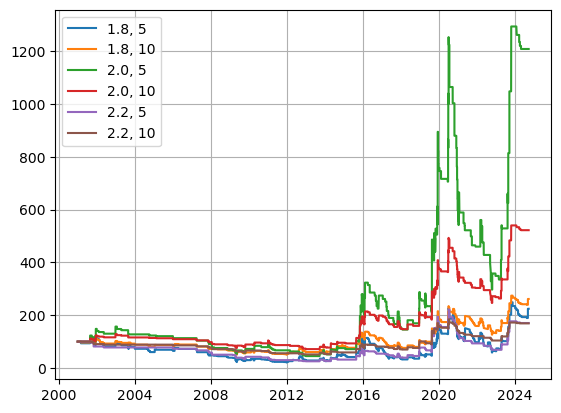

In [88]:
import matplotlib.pyplot as plt

def calc_bet(match, marg):

    bet = 'N'
    b = 0.0 # Represents the decimal odds - 1, i.e. the multiplier to calculate profit relative to the bet amount if the bet wins.

    # Check each outcome to see if the margin is exceeded. Place a bet on the outcome with the greatest margin.
    if match['H_prob'] * match['WHH'] > marg:
        bet = 'H'
        marg = match['H_prob'] * match['WHH']
        b = match['WHH'] - 1
        p = match['H_prob']
    if match['D_prob'] * match['WHD'] > marg:
        bet = 'D'
        marg = match['D_prob'] * match['WHD']
        b = match['WHD'] - 1
        p = match['D_prob']
    if match['A_prob'] * match['WHA'] > marg:
        bet = 'A'
        marg = match['A_prob'] * match['WHA']
        b = match['WHA'] - 1
        p = match['A_prob']

    # Calculate Kelly Criterion of the bet
    f = (((b + 1) * p) - 1) / b if b else 0.0
    f = np.maximum(f, 0.0)

    return bet, f, b

# Test different margins and fractions of the Kelly Criterion
margins = [1.8, 2.0, 2.2]
fracs = [5, 10]

for margin in margins:

    # Calculate the optimal bets for each match
    df_valid[['bet', 'f', 'b']] = df_valid.apply(lambda row: pd.Series(calc_bet(row, margin)), axis=1)

    for frac in fracs:

        df_valid['bankroll'] = 0.0
        bankroll = 100.0 # Start bankroll at 100
        for i, row in df_valid.iterrows():
            bet_amount = bankroll * row['f'] / frac # Kelly amount is divided by a set amount to decrease risk of ruin
            bet_profit = row['b'] * bet_amount if row['FTR'] == row['bet'] else 0.0 if row['bet'] == 'N' else -bet_amount # Calculate profit (or losses)
            bankroll += bet_profit
            df_valid.at[i, 'bet_amount'] = bet_amount
            df_valid.at[i, 'bet_profit'] = bet_profit
            df_valid.at[i, 'bankroll'] = bankroll

        # Plot bankroll over time
        plt.plot(df_valid['Date'], df_valid['bankroll'], label=f'{margin}, {frac}')

plt.legend()
plt.grid(True)
plt.show()

In [89]:
# Re-run process with optimal values
# I am using margin = 2.0, fraction = 1/5

df_valid[['bet', 'f', 'b']] = df_valid.apply(lambda row: pd.Series(calc_bet(row, 2.0)), axis=1)

df_valid['bankroll'] = 0.0

bankroll = 100.0
for i, row in df_valid.iterrows():
    bet_amount = bankroll * row['f'] / 5
    bet_profit = row['b'] * bet_amount if row['FTR'] == row['bet'] else 0.0 if row['bet'] == 'N' else -bet_amount
    bankroll += bet_profit
    df_valid.at[i, 'bet_amount'] = bet_amount
    df_valid.at[i, 'bet_profit'] = bet_profit
    df_valid.at[i, 'bankroll'] = bankroll

df_valid[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA', 'h_mean', 'a_mean', 'H_prob', 'D_prob', 'A_prob', 'pred_result', 'bet', 'f', 'b', 'bet_amount', 'bet_profit', 'bankroll']]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA,h_mean,a_mean,H_prob,D_prob,A_prob,pred_result,bet,f,b,bet_amount,bet_profit,bankroll
189,2000-12-26,Arsenal,Leicester,6,1,H,1.40,3.60,7.50,1.097739,0.478082,0.509415,0.330488,0.160097,H,N,0.0,0.0,0.0,0.0,100.000000
191,2000-12-26,Bradford,Sunderland,1,4,A,2.62,3.30,2.25,0.456205,0.837397,0.188313,0.389505,0.422182,A,N,0.0,0.0,0.0,0.0,100.000000
192,2000-12-26,Everton,Coventry,1,2,A,1.66,3.40,4.33,1.725954,0.817203,0.589828,0.235305,0.174865,H,N,0.0,0.0,0.0,0.0,100.000000
193,2000-12-26,Ipswich,Chelsea,2,2,D,2.30,3.10,2.75,1.620300,0.894486,0.544605,0.248073,0.207320,H,N,0.0,0.0,0.0,0.0,100.000000
194,2000-12-26,Man City,Derby,0,0,D,1.90,3.25,3.40,2.090822,1.099320,0.601356,0.206232,0.192400,H,N,0.0,0.0,0.0,0.0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,2024-09-28,Chelsea,Brighton,4,2,H,1.75,4.20,4.33,1.831707,0.942459,0.582779,0.226567,0.190651,H,N,0.0,0.0,0.0,0.0,1207.929133
8970,2024-09-28,Everton,Crystal Palace,2,1,H,2.75,3.40,2.60,0.744347,1.564265,0.177112,0.253515,0.569372,A,N,0.0,0.0,0.0,0.0,1207.929133
8971,2024-09-28,Nott'm Forest,Fulham,0,1,A,2.38,3.30,3.10,1.127627,1.054923,0.372131,0.292452,0.335417,H,N,0.0,0.0,0.0,0.0,1207.929133
8972,2024-09-28,Wolves,Liverpool,1,2,A,8.00,5.50,1.35,0.610624,1.886899,0.112277,0.208170,0.679547,A,N,0.0,0.0,0.0,0.0,1207.929133
